In [66]:
from dataset import Dataset
import vectorbt as vbt
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.ensemble import IsolationForest
from matplotlib.pyplot import figure

import warnings
warnings.simplefilter(action='ignore')
vbt.settings.set_theme('dark')

In [67]:
TICKER = 'BTCUSDT'
data_binance = Dataset().get_data(days=360, ticker=TICKER, ts='1h')

### creating features for a machine learning model

In [80]:
cols = []
data = data_binance.copy()
for i in range(0, 10):
    col = f'lag_{i}'
    col_vol = f'lag_vol_{i}'
    cols.append(col)
    cols.append(col_vol)
    data[col] = data['close'].pct_change().shift(i)
    data[col_vol] = data['volume'].pct_change().shift(i)

### creating target variables

In [83]:
targets = []
for i in range(1, 6):
    target = f'y_{i}'
    targets.append(target)
    data[target] = data['close'].pct_change().shift(-i)
data = data.dropna()



#### Isolation Forest Algorithm.

Return the anomaly score of each sample using the IsolationForest algorithm

The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node.

This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

Random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.

In [85]:
IF = IsolationForest(n_estimators=100, contamination=.03)
predictions = IF.fit_predict(data[cols])


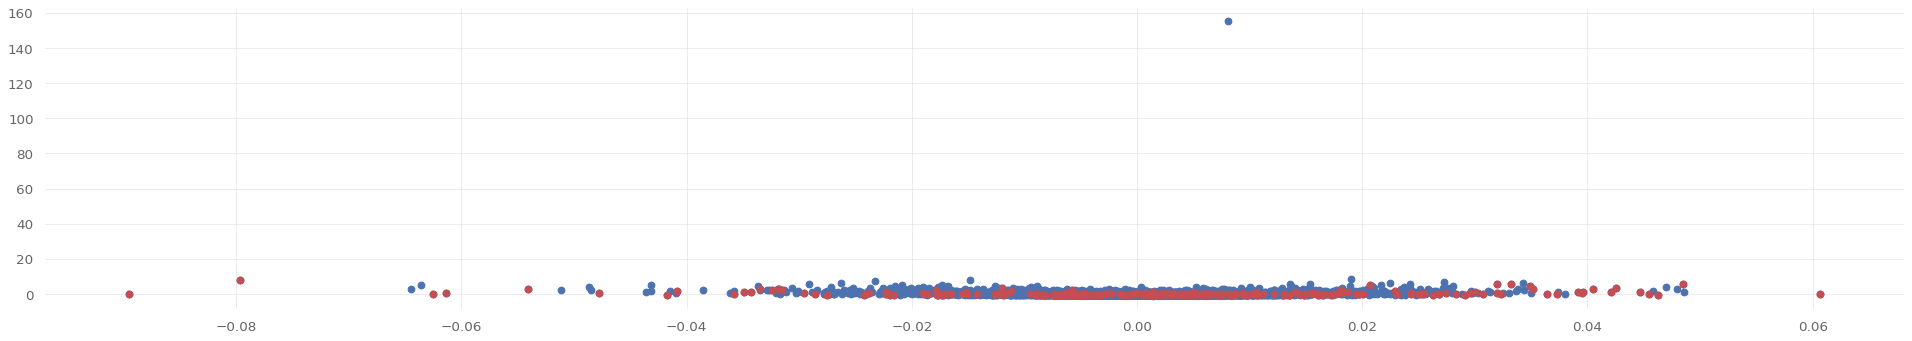

In [86]:
figure(figsize = (30, 5), dpi = 80)
outlier_index = np.where(predictions == -1)
values = data[cols[:2]].values[outlier_index]

plt.scatter(data[cols[0]].values, data[cols[1]].values)
plt.scatter(values[:, 0], values[:, 1], color='r')
plt.show()


In [87]:
data = data.reset_index()
data['outlier'] = False
data.loc[outlier_index[0], 'outlier'] = True
# data['outlier'] = np.where((data['outlier'] == True) & (data['lag_1'] > 0), True, False)
data = data.set_index('time')
data['outlier'].value_counts(True)

False    0.969971
True     0.030029
Name: outlier, dtype: float64

### Check ideas usings pandas

In [88]:
data.groupby(['outlier'])[targets].agg(['mean', 'sum'])

y_1                 y_2                 y_3                 y_4  \
             mean       sum      mean       sum      mean       sum      mean   
outlier                                                                         
False   -0.000046 -0.386020 -0.000023 -0.193979 -0.000047 -0.391192 -0.000032   
True     0.001464  0.379079  0.000736  0.190516  0.001439  0.372706  0.000942   

                        y_5            
              sum      mean       sum  
outlier                                
False   -0.267728 -0.000030 -0.252136  
True     0.244024  0.000877  0.227034

In [89]:
pf_kwargs = dict(size=np.inf, freq='1h')
pf = vbt.Portfolio.from_signals(
    data['close'],
    np.where(data['outlier'] == True, True, False),
    np.where(data['outlier'].shift(1) == True, True, False),
    **pf_kwargs
)
pf.plot(height=400, width=1300).show()

In [90]:
pf.stats()

Start                               2021-03-23 11:00:00
End                                 2022-03-18 06:00:00
Period                                359 days 09:00:00
Start Value                                       100.0
End Value                                    142.255151
Total Return [%]                              42.255151
Benchmark Return [%]                         -25.450485
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                              10.378822
Max Drawdown Duration                 137 days 12:00:00
Total Trades                                         97
Total Closed Trades                                  97
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                  55.670103
Best Trade [%]                                14.659928
Worst Trade [%]                               -4